In [1]:
# import talib
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import time
from ciso8601 import parse_datetime

from ftx_client import FtxClient

## API Init

In [2]:
api_key = '4MZCayt-zZKp3QQFOBgPFdwOK5B1zoxJPMeFAGKz'
api_secret = 'cfQxfctS5j7lR0iq-iGsiItt4znrH9P4AkF-IzMH'

client = FtxClient(api_key=api_key, api_secret=api_secret)

## Variables

In [3]:
resolution = 5*60 # 15 minutes in seconds
timeout = 10*60 # only enter a trade if this much time has passed since the last trade
num_stds = 20

startTime = None
endTime = None

market = 'BTC-PERP'

## HA Computation

1500
[{'close': 29735.5, 'high': 29781.5, 'low': 29729.5, 'open': 29756.0, 'startTime': '2021-01-02T06:30:00+00:00', 'time': 1609569000000.0, 'volume': 8398347.4421}, {'close': 29675.0, 'high': 29766.5, 'low': 29636.0, 'open': 29735.5, 'startTime': '2021-01-02T06:35:00+00:00', 'time': 1609569300000.0, 'volume': 7332205.4614}, {'close': 29698.0, 'high': 29734.5, 'low': 29675.0, 'open': 29675.0, 'startTime': '2021-01-02T06:40:00+00:00', 'time': 1609569600000.0, 'volume': 4439921.4788}, {'close': 29788.5, 'high': 29788.5, 'low': 29698.0, 'open': 29698.0, 'startTime': '2021-01-02T06:45:00+00:00', 'time': 1609569900000.0, 'volume': 2092419.01105}, {'close': 29810.5, 'high': 29850.0, 'low': 29785.0, 'open': 29788.5, 'startTime': '2021-01-02T06:50:00+00:00', 'time': 1609570200000.0, 'volume': 6348363.8985}]


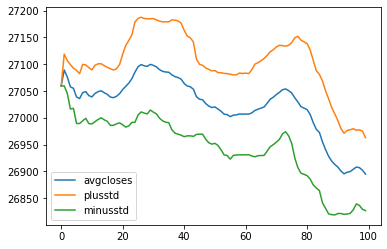

count:  320


In [4]:
past_candles = 1500

# utc_offset = time.timezone if (time.localtime().tm_isdst == 0) else time.altzone
# utc_offset = utc_offset / 60 / 60 * -1
# print('utc_offset: ', utc_offset)

# # Use only candles from the past x hours

# past_hours = 24
# utc_time = datetime.now() - timedelta(hours=(utc_offset))
# print('utc time: ', utc_time)

# start_datetime = utc_time - timedelta(hours = past_hours)
# start_timestamp = (start_datetime - datetime(1970, 1, 1)) / timedelta(seconds=1)
# print('start_timestamp: ', start_timestamp)
# end_timestamp = (utc_time - datetime(1970, 1, 1)) / timedelta(seconds=1)
# # candles = candles[-int(past_hours * (3600.0 / resolution)):]
# candles = client.get_historical_candles(market, resolution, start_timestamp, end_timestamp)

candles = client.get_candles(market, resolution)[-past_candles:]


N = len(candles)

print(N)
print(candles[-5:])

closes = [x['close'] for x in candles]

avgcloses_plusstds = []
avgcloses_minusstds = []
avgcloses = []

for i in range(len(closes)):
    std = np.std(np.array(closes[max(0, i - num_stds + 1) : i + 1]))
    avg = np.mean(np.array(closes[max(0, i - num_stds + 1) : i + 1]))
    avgcloses.append(avg)
    avgcloses_plusstds.append(avg + std)
    avgcloses_minusstds.append(avg - std)
    
plt.plot(avgcloses[:100], label='avgcloses')
plt.plot(avgcloses_plusstds[:100], label='plusstd')
plt.plot(avgcloses_minusstds[:100], label='minusstd')
plt.legend()
plt.show()

count = 0
for i in range(len(closes)):
    if closes[i] <= avgcloses_minusstds[i]:
        count += 1
print('count: ', count)

In [5]:
ha_c = []
ha_o = []
ha_high = []
ha_low = []

ha_c.append(sum([candles[0][x] for x in ['high', 'low', 'open', 'close']]) / 4)
ha_o.append((candles[0]['open'] + candles[0]['close']) / 2)
ha_high.append(candles[0]['high'])
ha_low.append(candles[0]['low'])

for i in range(1, N):
    candle = candles[i]
    
    ha_c.append(sum([candle[x] for x in ['high', 'low', 'open', 'close']]) / 4)
    ha_o.append((ha_c[i-1] + ha_o[i-1]) / 2)
    ha_high.append(max([candle['high'], ha_c[i], ha_o[i]]))
    ha_low.append(min([candle['low'], ha_c[i], ha_o[i]]))
    
print(len(ha_c))
print(ha_c[:10])

1500
[27069.875, 27091.5, 27090.75, 27003.25, 27030.25, 26997.25, 26998.875, 27081.25, 27086.0, 27010.375]


## Backtest criterions

In [6]:
"""
params:
- prices -> Heiken-Ashi close prices till now, last price is most current candle
- last_sell_idx -> idx of candle of last closed trade
"""

def buy_criterion1(params):
    prices = params['ha_prices']
    last_sell_idx = params['last_sell_idx']
    
    condition = prices[-1] > prices[-2]
    
    if condition:
        return True
    return False

def buy_criterion2(params):
    prices = params['ha_prices']
    last_sell_idx = params['last_sell_idx']
    
    condition1 = prices[-1] > prices[-2]
    
    condition2 = float(len(prices) - last_sell_idx) * resolution > timeout
    
    condition = condition1 and condition2
    
    if condition:
        return True
    return False

def buy_criterion3(params):
    prices = params['ha_prices']
    hit_bottom_std = params['hit_bottom_std']
    
    condition1 = prices[-1] > prices[-2]
    
    if hit_bottom_std and condition1:
        return True
    return False

def buy_criterion4(params):
    prices = params['ha_prices']
    hit_bottom_std = params['hit_bottom_std']
    last_sell_idx = params['last_sell_idx']
    
    condition1 = prices[-1] > prices[-2]
    
    condition2 = float(len(prices) - last_sell_idx) * resolution > timeout
    
    if hit_bottom_std and condition1 and condition2:
        return True
    return False

def sell_criterion(params):
    prices = params['ha_prices']
    
    condition = prices[-1] < prices[-2]
    
    if condition:
        return True
    return False

## Backtest

In [7]:
balance = {'USD': 1000.0, 'BTC': 0.0}
min_criterion_candles = 2 # Minimum number of candles in the past which are required for buy/sell criterions.
                          # Includes current candle

activeLong = False
numTrades = 0

last_sell_idx = -100

hit_bottom_std = False

for t in range(min_criterion_candles - 1, N):
    params = {'ha_prices': ha_c[:(t + 1)],
              'closes': closes[:(t + 1)],
             'last_sell_idx': last_sell_idx}
    
    # If we have hit a bottom standard deviation
    if not activeLong and closes[t] <= avgcloses_minusstds[t]:
        hit_bottom_std = True
        
    params['hit_bottom_std'] = hit_bottom_std
    
    if not activeLong and buy_criterion4(params):
        print('Entering long at close = ', closes[t])
        print('Old balance = {}\n'.format(balance['USD']))
        
        activeLong = True
        balance['BTC'] = balance['USD'] / closes[t]
        balance['USD'] = 0.0
        
    if activeLong and sell_criterion(params):
        print('Exiting long at close = ', closes[t])
        
        newBalance = balance['BTC'] * closes[t]
        
        print('New balance = {}\n'.format(newBalance))
        
        activeLong = False
        balance['USD'] = newBalance
        balance['BTC'] = 0.0
        numTrades += 1
        last_sell_idx = t
        hit_bottom_std = False
        
final_usd = balance['USD']
if final_usd == 0.0:
    final_usd = balance['BTC'] * ha_c[-1]
        
print('final balance: ', final_usd)
print('number of trades: ', numTrades)

Entering long at close =  27044.0
Old balance = 1000.0

Exiting long at close =  26958.5
New balance = 996.8384854311493

Entering long at close =  27115.5
Old balance = 996.8384854311493

Exiting long at close =  26996.0
New balance = 992.4453450129743

Entering long at close =  27086.0
Old balance = 992.4453450129743

Exiting long at close =  27170.0
New balance = 995.5231493761542

Entering long at close =  27056.5
Old balance = 995.5231493761542

Exiting long at close =  27008.0
New balance = 993.7386291039554

Entering long at close =  27052.0
Old balance = 993.7386291039554

Exiting long at close =  27053.0
New balance = 993.7753634906591

Entering long at close =  26993.5
Old balance = 993.7753634906591

Exiting long at close =  26906.0
New balance = 990.554019674354

Entering long at close =  26956.5
Old balance = 990.554019674354

Exiting long at close =  26909.5
New balance = 988.8269394182119

Entering long at close =  26958.5
Old balance = 988.8269394182119

Exiting long at